## Кластеризация на эмбеддингах нейросети

Кластеризация MNIST по векторным представлениям (эмбеддингам) ResNet-18 с сравнением алгоритмов кластеризации.

In [27]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

---
## 1. Данные MNIST

Используем датасет MNIST с Hugging Face.

In [8]:
HF_CACHE_DIR = "./hf_cache"
dataset = load_dataset("mnist", cache_dir=HF_CACHE_DIR)
ds_train = dataset["train"]

# Подвыборка из 10 000 случайных объектов
N_TRAIN = 10_000
ds_sample = ds_train.shuffle(seed=SEED).select(range(N_TRAIN))

X_list = []
y_true_list = []
for item in ds_sample:
    img = item["image"]
    label = item["label"]
    arr = np.array(img, dtype=np.float32)
    X_list.append(arr)
    y_true_list.append(label)

X = np.stack(X_list, axis=0)
y_true = np.array(y_true_list)

print("Форма матрицы признаков X:", X.shape)
print("Форма вектора меток y_true:", y_true.shape)

Форма матрицы признаков X: (10000, 28, 28)
Форма вектора меток y_true: (10000,)


Загружены данные MNIST и подвыборка из 10 000 объектов. Изображения в формате (28, 28), метки сохранены в `y_true` для последующей оценки ARI/NMI.

---
## 2. Эмбеддинги ResNet-18

ResNet-18 используется только как экстрактор признаков. Grayscale MNIST (28×28) приводим к виду, ожидаемому ResNet: три канала (копия одного) и ресайз до 224×224.

In [11]:
class MNISTEmbedDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx] # image of shape (28, 28)
        x = torch.from_numpy(x).float().unsqueeze(0) # pytorch тензор
        x = x / 255.0 # нормализация пикселей grayscale [0, 255] -> [0, 1]
        x = (x - 0.5) / 0.5 # нормализация пикселей [0, 1] -> [-1, 1] (для ResNet zero-centered)
        x = x.repeat(3, 1, 1) # добавление двух каналов (fake RGB)
        x = torch.nn.functional.interpolate(
            x.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False  # 3D to 4D (batch, channels, height, width)
        ).squeeze(0) # remove batch dimension
        return x # возвращаем тензор (3, 224, 224) для ResNet

embed_dataset = MNISTEmbedDataset(X)
embed_loader = DataLoader(embed_dataset, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
# ResNet-18 как экстрактор
def get_resnet18_encoder():
    try:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except AttributeError:
        model = models.resnet18(pretrained=True)
    model.fc = nn.Identity() # убираем последний FC-слой, выход после Average Pooling — 512
    return model

encoder = get_resnet18_encoder()
encoder.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/Ivanov/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 31.9MB/s]


In [12]:
# Этап извлечения эмбеддингов
# Проходим по батчам без градиентов - так как это не требуется для экстрактора признаков,
# так как никакого обучения тут не происходит.
embeddings_list = []
with torch.no_grad():
    for batch in embed_loader:
        batch = batch.to(device)
        out = encoder(batch)
        embeddings_list.append(out.cpu().numpy())

X_emb = np.vstack(embeddings_list)
print("Форма эмбеддингов X_emb:", X_emb.shape)

Форма эмбеддингов X_emb: (10000, 512)


Таким образом для каждого изображения получен вектор эмбеддингов размерности 512. Эмбеддинги содержат семантические признаки, извлечённые предобученной сетью, что обычно даёт более осмысленную кластеризацию, чем по сырым пикселям.

---
## 3. Кластеризация

Применяем три алгоритма на эмбеддингах: **KMeans** (k=10), **AgglomerativeClustering** (n_clusters=10, linkage='ward') и **DBSCAN** (density-based, без заданного числа кластеров). Признаки предварительно масштабируем StandardScaler.

In [28]:
# Масштабирование эмбеддингов для алгоритмов, чувствительных к масштабу
scaler_emb = StandardScaler()
X_emb_scaled = scaler_emb.fit_transform(X_emb)

N_CLUSTERS = 10

# KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init="auto")
labels_kmeans = kmeans.fit_predict(X_emb_scaled)

# AgglomerativeClustering (Ward)
agg = AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage="ward")
labels_agg = agg.fit_predict(X_emb_scaled)

print("KMeans: уникальных меток", len(np.unique(labels_kmeans)))
print("Agglomerative: уникальных меток", len(np.unique(labels_agg)))

KMeans: уникальных меток 10
Agglomerative: уникальных меток 10


KMeans и Agglomerative выдают ровно по 10 кластеров (задано явно). По кластеру на число.

---
## 4. Метрики качества

Считаем **три метрики**: внутреннюю **silhouette**, внешние **ARI** и **NMI** (дополнительная метрика для сравнения алгоритмов). Сводная таблица по обоим алгоритмам.

In [29]:
def compute_metrics(X, labels, y_true):
    n_clusters = len(np.unique(labels))
    sil = silhouette_score(X, labels) if n_clusters > 1 else np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)
    return {"n_clusters": n_clusters, "silhouette": sil, "ari": ari, "nmi": nmi}

cluster_results = {}
cluster_results["KMeans"] = compute_metrics(X_emb_scaled, labels_kmeans, y_true)
cluster_results["Agglomerative"] = compute_metrics(X_emb_scaled, labels_agg, y_true)

df_metrics = pd.DataFrame(cluster_results).T
df_metrics

,n_clusters,silhouette,ari,nmi
KMeans,10.0,0.062572,0.354016,0.503911
Agglomerative,10.0,0.056956,0.551335,0.684099


**Silhouette Score**: Обе оценки очень близки к нулю. Это значит, что кластеры сильно перекрываются — объекты на границах кластеров почти одинаково близки и к своему, и к соседнему кластеру. Это нормально для MNIST в пространстве ResNet: цифры вроде 4/9, 3/5, 7/1 визуально похожи, и их эмбеддинги тоже близки. По silhouette оба алгоритма практически одинаковы — кластеры одинаково размытые.

**ARI**:
0 = случайное разбиение, 1 = идеальное совпадение с истинными метками.

KMeans=0.354 — слабое совпадение. Грубо говоря, KMeans правильно группирует примерно 30%.Многие цифры раскиданы между разными кластерами или смешаны.

Agglomerative=0.551 - заметно лучше. Иерархическая кластеризация с linkage Ward значительно точнее отражает реальное деление на цифры. Она лучше справляется с кластерами неправильной формы, которые KMeans разбивает некорректно.

**NMI**: 
0 = кластеры не несут информации о метках, 1 = зная кластер, знаешь цифру.

KMeans=0.504 — зная, в какой кластер попал объект, цифра угадывается чуть лучше, чем наполовину от идеала.

Agglomerative=0.684 — зная кластер, иожно предсказать цифру с существенно большей уверенностью. 

**Итог**:
Agglomerative clustering однозначно лучше KMeans и по ARI, и по NMI. При этом оба алгоритма далеки от идеала (ARI/NMI далеко от 1), что говорит о том, что некоторые цифры (скорее всего 4/9, 3/5/8, 1/7) в эмбеддингах ResNet-18 плохо разделяются.

---
## 5. Визуализация

Понижаем размерность эмбеддингов с помощью **PCA**.

In [ ]:
# проецируем 512-мерные эмбеддинги на 2D
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_emb_scaled)

Объяснённая доля дисперсии PCA: [0.0928 0.0673]


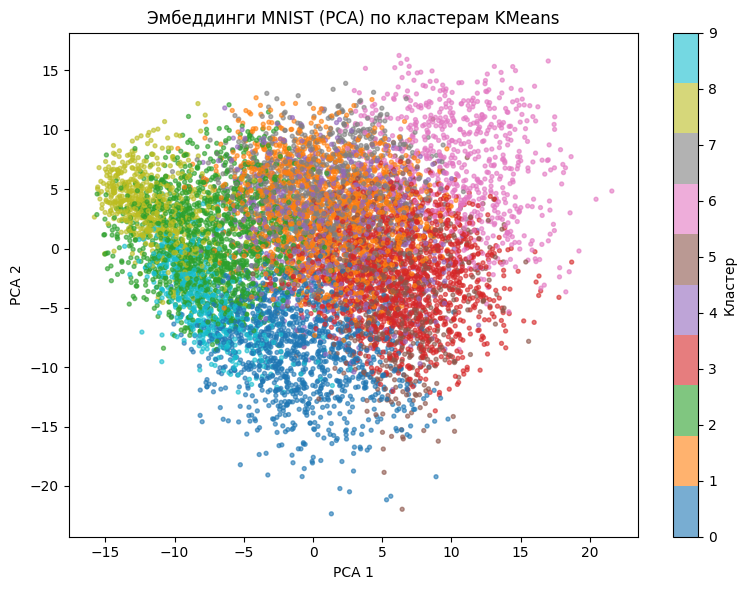

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels_kmeans, cmap="tab10", alpha=0.6, s=8
)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Эмбеддинги MNIST (PCA) по кластерам KMeans")
plt.colorbar(scatter, ax=ax, label="Кластер")
plt.tight_layout()
plt.show()

На графике видно, как KMeans разбил объекты на 10 кластеров в пространстве двух главных компонент. Перекрытие кластеров говорит о том, что границы между цифрами в эмбеддингах не идеальны.

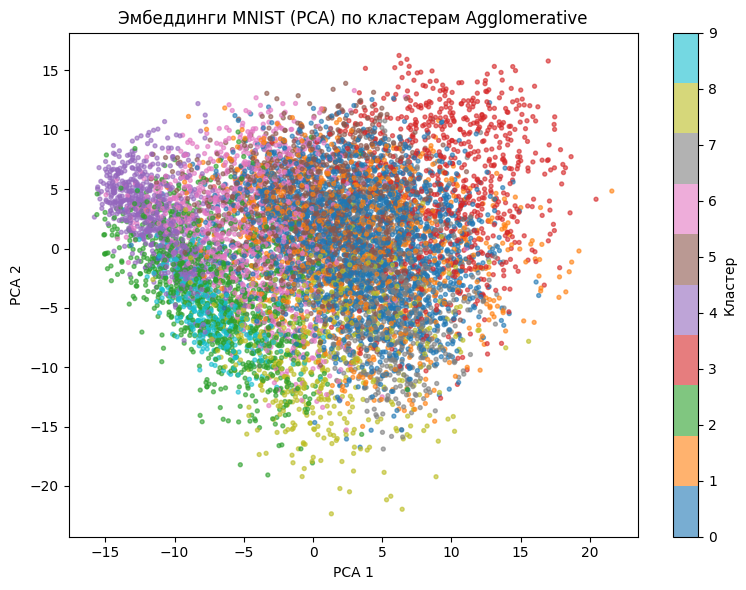

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels_agg, cmap="tab10", alpha=0.6, s=8
)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Эмбеддинги MNIST (PCA) по кластерам Agglomerative")
plt.colorbar(scatter, ax=ax, label="Кластер")
plt.tight_layout()
plt.show()

Для Agglomerative также свойственно очень сильное перекрытие

In [22]:
# Дополнительно: t-SNE на подвыборке (медленно на 10k) для Agglomerative с раскраской по кластерам
n_sub = 2000
idx_sub = np.random.RandomState(SEED).choice(len(X_emb_scaled), n_sub, replace=False)
X_sub = X_emb_scaled[idx_sub]
y_sub = y_true[idx_sub]
lab_agg_sub = labels_agg[idx_sub]

tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
X_tsne = tsne.fit_transform(X_sub)

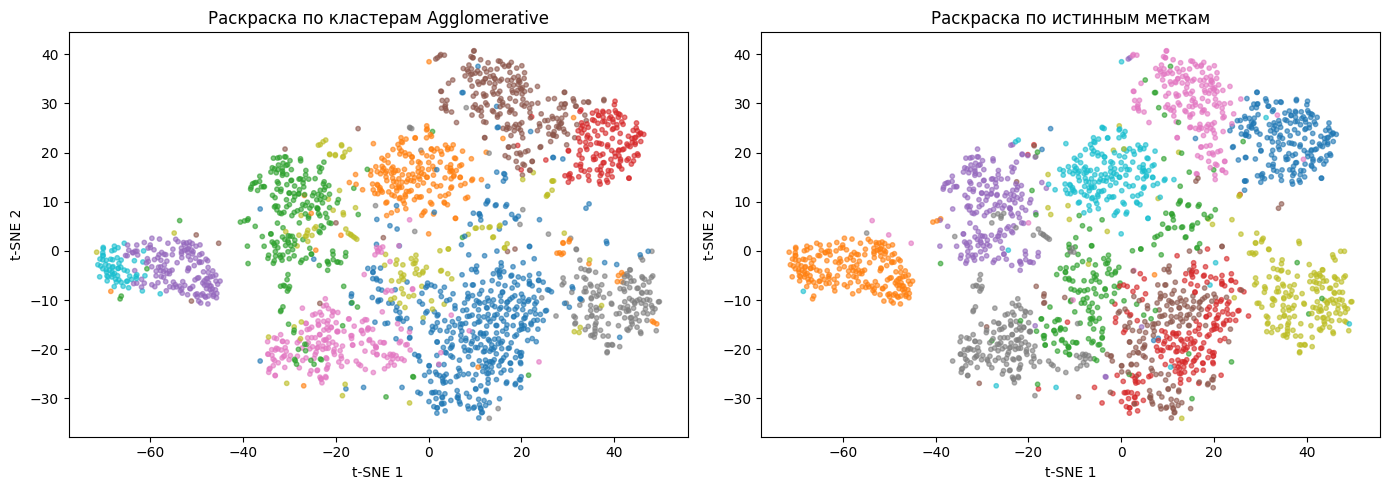

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=lab_agg_sub, cmap="tab10", alpha=0.6, s=10)
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].set_title("Раскраска по кластерам Agglomerative")
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap="tab10", alpha=0.6, s=10)
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].set_title("Раскраска по истинным меткам")
plt.tight_layout()
plt.show()

t-SNE на подвыборке 2000 объектов: слева — кластеры Agglomerative, справа — истинные цифры. По ним можно оценить, насколько признаки полученные через эмбединги согласуются с метками.